In [34]:
import os
import numpy as np
import pandas as pd
import keras
import shutil

import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [9]:
image_path = 'celeba-dataset/img_align_celeba'
attributes_path = 'celeba-dataset/list_attr_celeba.csv'
image_folder = 'categories'

### Load attribute data:

In [4]:
attributes_df = pd.read_csv(attributes_path)
attributes_df.columns.values

array(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee',
       'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
       'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'], dtype=object)

In [6]:
attributes_to_keep = ['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Brown_Hair',
       'Bushy_Eyebrows', 'Goatee',
       'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pointy_Nose', 'Smiling', 'Straight_Hair',
       'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Young']
attribute_data = attributes_df[attributes_to_keep]
attribute_data = attribute_data.values[:,1:] # note that index starts with 0 and image id with 1!


### Load image data:



### Define data generators

In [18]:
target_size = (128, 128)
input_shape = (target_size[0], target_size[1], 3)
batch_size = 64

data_generator = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)

train_generator = data_generator.flow_from_directory(image_folder, 
                                                     target_size=target_size, 
                                                     batch_size=batch_size)


Found 202599 images belonging to 202599 classes.


In [20]:
x, y = train_generator.next()
y = np.argmax(y, axis = 1)

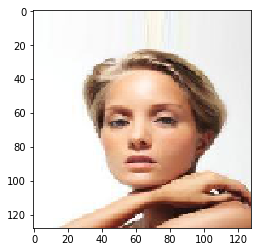

In [96]:
plt.imshow(x[10])

## Define networks:


### Parameters

In [130]:
latent_dim = 128
epochs = 3
save_interval = 1
batches_per_epoch = 3#train_generator.n // batch_size

### Create Generator

In [131]:
def build_generator():

    model = Sequential()

    model.add(Dense(128 * 8 * 8, activation="relu", input_dim=latent_dim))
    model.add(Reshape((8, 8, 128)))
    model.add(UpSampling2D())
    
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    
    model.add(Conv2D(32, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    
    model.add(Conv2D(3, kernel_size=3, padding="same"))
    model.add(Activation("sigmoid"))

    #model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

def build_discriminator():

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=input_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    #model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    #model.summary()

    img = Input(shape=input_shape)
    validity = model(img)

    return Model(img, validity)

### Define the models!

In [132]:
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=optimizer,
                      metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [133]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,:])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/celebA_%d.png" % epoch)
    plt.close()

### Train!

In [135]:
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------
    for i_batch in range(batches_per_epoch):
    # Select a random batch of images
        print('minibatch: %d' %i_batch)
        imgs, y = train_generator.next()

        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator (wants discriminator to mistake images as real)
        g_loss = combined.train_on_batch(noise, valid)

    # Plot the progress
    print ("epoch: %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
    
    # If at save interval => save generated image samples
    if epoch % save_interval == 0:
        save_imgs(epoch)

    

minibatch: 0


/anaconda3/envs/dml/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


minibatch: 1
minibatch: 2
epoch: 0 [D loss: 0.870419, acc.: 53.91%] [G loss: 2.182853]
minibatch: 0
minibatch: 1
minibatch: 2
epoch: 1 [D loss: 0.521493, acc.: 73.44%] [G loss: 2.402512]
minibatch: 0
minibatch: 1
minibatch: 2
epoch: 2 [D loss: 0.523484, acc.: 75.00%] [G loss: 2.432292]


In [113]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 128)               0         
_________________________________________________________________
sequential_26 (Sequential)   (None, 128, 128, 3)       1298371   
Total params: 1,298,371
Trainable params: 1,297,923
Non-trainable params: 448
_________________________________________________________________
